# Melanoma Detection

### Problem statement:
 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Project Pipeline:
- Data Reading/Data Understanding
- Dataset Creation
- Dataset visualisation
- Model Building & training
- Model overfit or underfit Analysis
- Model Building & training on the augmented data
- Class Distribution Analysis
- Handling class imbalances
- Model Building & training on the rectified class imbalance data
- Final Conclusion

##### Importing all the important libraries


In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
## We are using the data by mounting the google drive
from google.colab import drive
drive.mount("/content/drive/")
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
drive  sample_data


- This assignment uses a dataset of about 2357 images of skin cancer types.
- The dataset contains 9 sub-directories in each train and test subdirectories.
- The 9 sub-directories contains the images of 9 skin cancer types respectively.

### 1. Data Reading/Data Understanding

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### 2. Dataset Creation

Creating train & validation dataset from the train directory with a batch size of 32. and resizeing images to 180*180.


In [8]:
#Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Loading images off disk using the helpful image_dataset_from_directory utility of Keras.

Using 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,               # Directory containing the training images
    labels='inferred',            # How to determine labels ('inferred' infers labels from subdirectory structure)
    label_mode='categorical',     # Type of labels ('categorical' for one-hot encoded labels)
    class_names=None,             # List of class names (if not provided, it's inferred from subdirectories)
    color_mode='rgb',             # Color mode for images ('rgb' for color, 'grayscale' for grayscale)
    shuffle=True,                 # Whether to shuffle the dataset
    seed=123,                     # Seed for shuffling (for reproducibility)
    validation_split=0.2,         # Fraction of data to reserve for validation
    subset='training',            # Whether to create a training or validation subset
    interpolation='bilinear',    # Interpolation method for resizing images
    follow_links=False,           # Whether to follow symbolic links in the directory
    smart_resize=False,           # Whether to perform smart resizing (used with 'interpolation')
    image_size=(img_height, img_width),  # Target image size
    batch_size=batch_size         # Size of batches in the dataset
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,               # Directory containing the training images
    labels='inferred',            # How to determine labels ('inferred' infers labels from subdirectory structure)
    label_mode='categorical',     # Type of labels ('categorical' for one-hot encoded labels)
    class_names=None,             # List of class names (if not provided, it's inferred from subdirectories)
    color_mode='rgb',             # Color mode for images ('rgb' for color, 'grayscale' for grayscale)
    shuffle=True,                 # Whether to shuffle the dataset
    seed=123,                     # Seed for shuffling (for reproducibility)
    validation_split=0.2,         # Fraction of data to reserve for validation
    subset='validation',            # Whether to create a training or validation subset
    interpolation='bilinear',    # Interpolation method for resizing images
    follow_links=False,           # Whether to follow symbolic links in the directory
    smart_resize=False,           # Whether to perform smart resizing (used with 'interpolation')
    image_size=(img_height, img_width),  # Target image size
    batch_size=batch_size         # Size of batches in the dataset
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### 3. Dataset visualisation
#### Creating a code to visualize one instance of all the nine classes present in the dataset

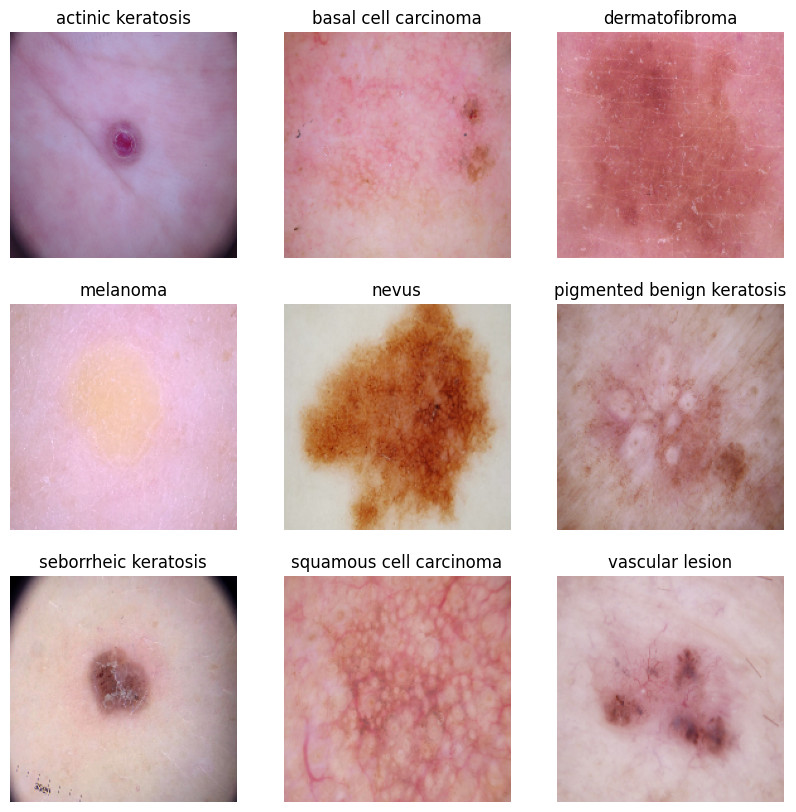

In [12]:
### Creating a code to visualize one instance of all the nine classes present in the dataset

plt.figure(figsize=(10, 10))
for img, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 4. Model Building & training
Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

The CNN model consists of the following layers:

* 2 convolution layers following a maxpool and dropout
* 1 FC layer folllowing a dropout
* output using softmax

In [15]:
# Building CNN model with 9 classes
num_classes = 9

model = Sequential([
  ## Standardizing input
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # 1st Convolution Layer
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.1),

  # 2nd Convolution Layer
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.1),

  layers.Flatten(),

  # Fully connected Layer
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  # Output
  layers.Dense(num_classes,activation='softmax')

])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:

### Choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 455s 2s/step - loss: 3.0842 - accuracy: 0.1814 - val_loss: 2.1234 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 1.9010 - accuracy: 0.2974 - val_loss: 1.9327 - val_accuracy: 0.3982
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 1.7398 - accuracy: 0.3733 - val_loss: 1.7943 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 3s 53ms/step - loss: 1.6765 - accuracy: 0.4068 - val_loss: 1.6463 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 1.5318 - accuracy: 0.4738 - val_loss: 1.5573 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 3s 53ms/step - loss: 1.5321 - accuracy: 0.4671 - val_loss: 1.5652 - val_accuracy: 0.4609
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4403 - accuracy: 0.4900 - val_loss: 1.4762 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing training results

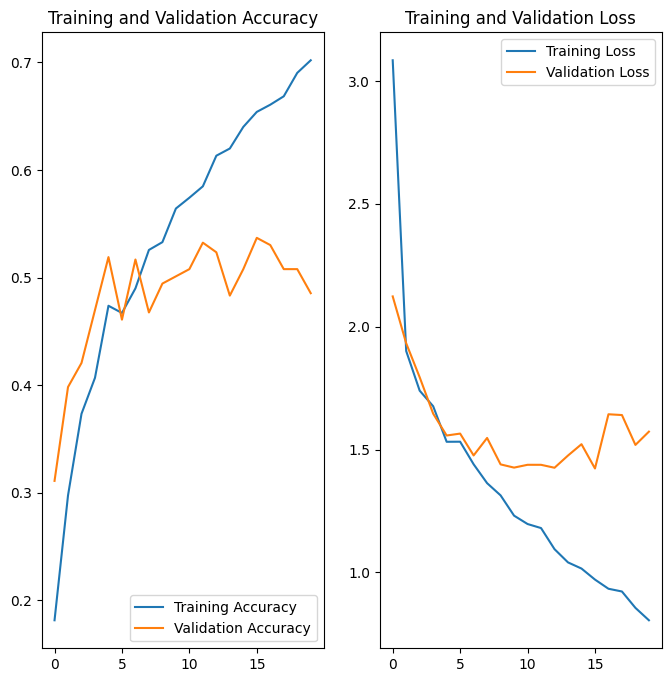

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


##### Observations:

- Training Loss: 0.80
- Training Accuracy: 70%

- Validation Loss: 1.5
- Validation Accuracy: 48%

The training loss is relatively low, indicating that the model is fitting the training data well, with an accuracy over 89%. however, there is a significant discrepancy between the training and validation performance. The validation loss is substantially higher, and the validation accuracy is lower (53%).

Observed overfiting of the model as there is significant difference in accuracy of training and validation data set.


#### 5. Fixing Overfitting using Data Augmentation
- We will fix  overfitting by introducing diversity in the given samples.

- We will use flip, rotate, zoom, contrast, etc on the existing images to generate new ones.

In [20]:

# After analysing the model fit history for presence of underfit or overfit, creating an appropriate data augumentation strategy.
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
  ]
)

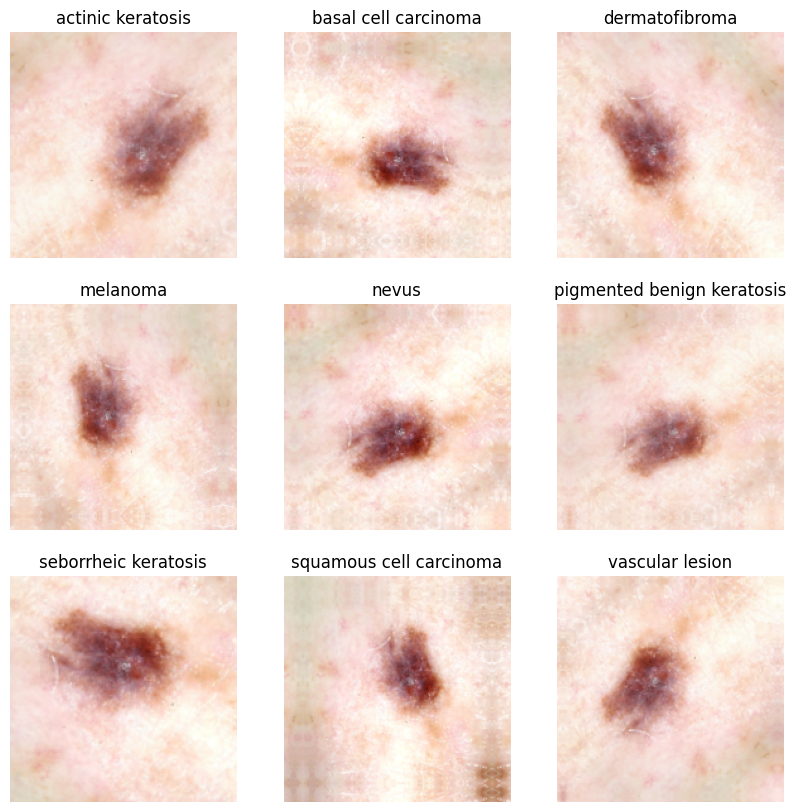

In [21]:
# Visualization of augmentation strategy for one instance of training image.

plt.figure(figsize=(10, 10))

for image, label in train_ds.take(1):
    for i in range(len(class_names)):
        augmented_image = data_augmentation(image)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")



#### 6. Model Creation and Training after Data Augmentation

Crating and training the model on augumented data

Model Architecture:-

* Three convolution layers following a maxpool and dropout
* 1 FC layer + Dropout layer
* output using softmax


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model = Sequential([

  ## Standardizing input
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  # 1st Convolution Layer
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.Conv2D(32, (3,3), padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),

  # 2nd Convolution Layer
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.Conv2D(64, (3,3), padding='same'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),

  # 3rd Convolution Layer
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.Conv2D(128, (3,3), padding='same'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(),

  # Fully connected Layer
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  # Output
  layers.Dense(num_classes,activation='softmax')

])


### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 32)        0         
                                                      

### Training the model

In [25]:
# Training the model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 153ms/step - loss: 2.9192 - accuracy: 0.1624 - val_loss: 2.0566 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 7s 134ms/step - loss: 1.8201 - accuracy: 0.3170 - val_loss: 1.6319 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 8s 137ms/step - loss: 1.6991 - accuracy: 0.3878 - val_loss: 1.7129 - val_accuracy: 0.3915
Epoch 4/20
56/56 [==============================] - 8s 140ms/step - loss: 1.6292 - accuracy: 0.4230 - val_loss: 1.5374 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 7s 132ms/step - loss: 1.5413 - accuracy: 0.4587 - val_loss: 1.5105 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 7s 133ms/step - loss: 1.5317 - accuracy: 0.4559 - val_loss: 1.5106 - val_accuracy: 0.4631
Epoch 7/20
56/56 [==============================] - 7s 132ms/step - loss: 1.6239 - accuracy: 0.4174 - val_loss: 1.4489 - val_accuracy: 0.5190
Epoch

### Visualizing the results

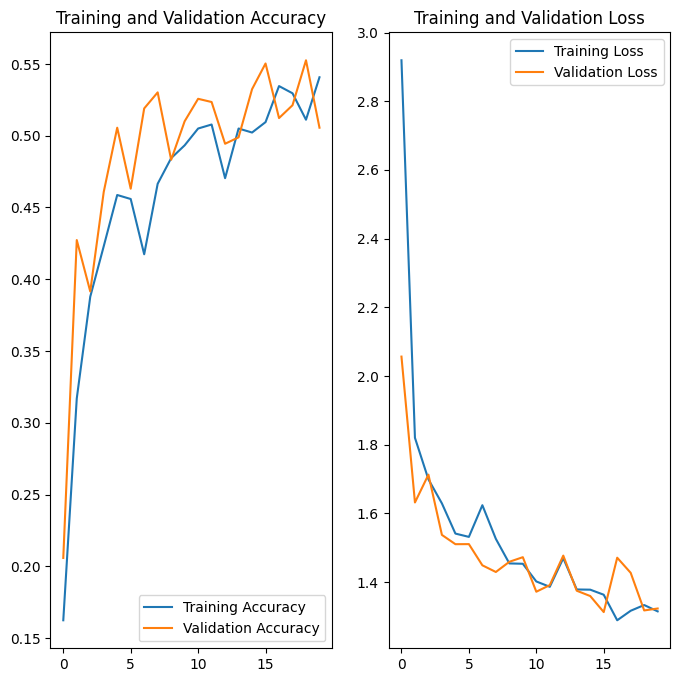

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Observations:

- Training Loss: 1.31
- Training Accuracy: 54%

- Validation Loss: 1.32
- Validation Accuracy: 50%

- The issue of overfitting observed in the previous run has shown signs of improvement.

- Following data augmentation, the training accuracy and validation accuracy have become more aligned in terms of their values.

- Despite these improvements, the overall accuracy remains quite low.

- The training loss appears to be on the higher side, suggesting that the model is encountering challenges in effectively learning from the training data.

To tackle this issue, you may want to explore potential enhancements such as modifying the model's architecture, tuning hyperparameters, or expanding the training dataset size. These adjustments can help enhance the model's capacity to grasp the inherent patterns within the data.

Lets check for class imbalance to improvise the scores better.

### 7. Find the distribution of classes in the training dataset.
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.

from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [28]:

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,drive/MyDrive/app/Skin cancer ISIC The Interna...,melanoma
1,drive/MyDrive/app/Skin cancer ISIC The Interna...,melanoma
2,drive/MyDrive/app/Skin cancer ISIC The Interna...,melanoma
3,drive/MyDrive/app/Skin cancer ISIC The Interna...,melanoma
4,drive/MyDrive/app/Skin cancer ISIC The Interna...,melanoma
...,...,...
2234,drive/MyDrive/app/Skin cancer ISIC The Interna...,dermatofibroma
2235,drive/MyDrive/app/Skin cancer ISIC The Interna...,dermatofibroma
2236,drive/MyDrive/app/Skin cancer ISIC The Interna...,dermatofibroma
2237,drive/MyDrive/app/Skin cancer ISIC The Interna...,dermatofibroma


In [29]:

# find the distribution of each class

count = {}
df = pd.DataFrame()
for i in range(len(class_names)):
  count[i] = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
df['class'] = class_names
df['count'] = count
df.head(10)

,class,count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


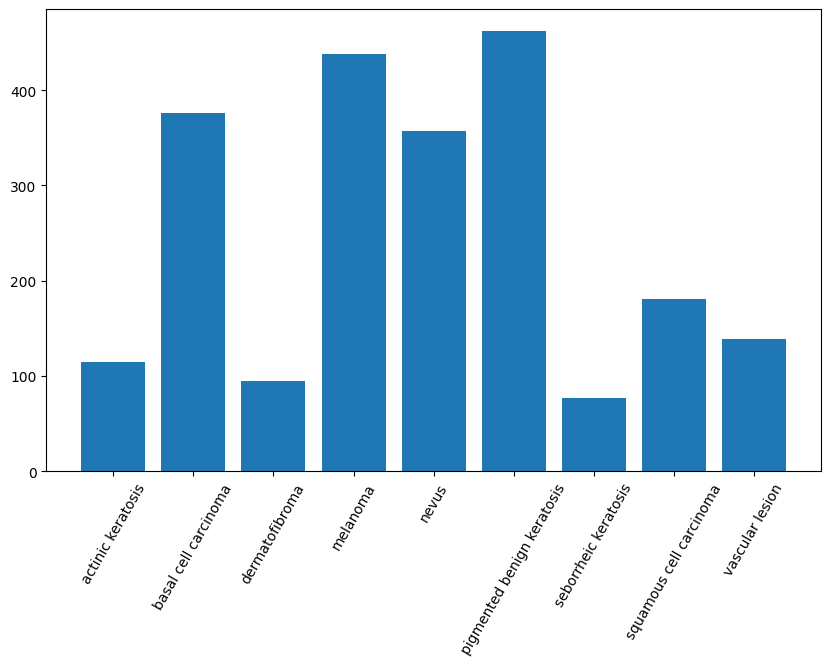

In [30]:
# plot a bar chart of the distribution

plt.figure(figsize=(10, 6))
plt.bar(df['class'], df['count'])
plt.xticks(rotation=60)
plt.show()


#### Observations:
- Which class has the least number of samples?
   - seborrheic keratosis has least number of samples- 77

- Which classes dominate the data in terms proportionate number of samples?
   - 'nevus' - 357
   -  'basal cell carcinoma' -376
   - 'melanoma' -438
   - 'pigmented benign keratosis'- 462
   

  These Classes dominates the data in terms proportionate number of samples.


Class Imbalance Detected: We'll use data augmentation to balance the class distribution.

Data augmentation helps generate additional training samples for underrepresented classes.

#### 8. Rectify the class imbalance

We need to Rectify the class imbalance

**Context:** we can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset="drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C0CF5B9FCA0>: 100%|██████████| 500/500 [00:21<00:00, 23.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C0CF5BEB5B0>: 100%|██████████| 500/500 [00:21<00:00, 23.47 Samples/s]


Initialised with 95 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C0D316F0430>: 100%|██████████| 500/500 [00:22<00:00, 21.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C0D317FB7F0>: 100%|██████████| 500/500 [01:18<00:00,  6.39 Samples/s]


Initialised with 357 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C0CE4B304F0>: 100%|██████████| 500/500 [01:13<00:00,  6.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C0CF5B40820>: 100%|██████████| 500/500 [00:18<00:00, 26.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C0DCBA0EF80>: 100%|██████████| 500/500 [00:37<00:00, 13.17 Samples/s]


Initialised with 181 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C0D1FFCCC70>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to drive/MyDrive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C0D31A677F0>: 100%|██████████| 500/500 [00:18<00:00, 27.34 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-37-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [38]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### 9. Train the Model on Augumented data

We will now train the model on final data treated with menthods to resolve overfitting and class imbalnce

In [39]:
batch_size = 32
img_height = 180
img_width = 180

##### Creating Training Dataset

In [40]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


##### Creating a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating model (make sure to include normalization)

In [42]:
# Peformance Tuning
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([


  ## Standardizing input
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # 1st Convolution Layer
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.1),

  # 2nd Convolution Layer
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.25),

  # 3rd Convolution Layer
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.25),

  # 4th Convolution Layer
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.25),

  layers.Flatten(),
  layers.Dropout(0.25),
  # Fully connected Layer
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.25),

  # Output
  layers.Dense(num_classes,activation='softmax')

])



##### Compiling the model
Choosing the optimizer and loss function appropriately

In [43]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

##### Training the model

In [44]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 41s 77ms/step - loss: 2.1526 - accuracy: 0.1599 - val_loss: 1.9708 - val_accuracy: 0.2368
Epoch 2/30
169/169 [==============================] - 5s 29ms/step - loss: 1.8318 - accuracy: 0.2780 - val_loss: 1.7315 - val_accuracy: 0.3007
Epoch 3/30
169/169 [==============================] - 5s 29ms/step - loss: 1.6204 - accuracy: 0.3668 - val_loss: 1.4652 - val_accuracy: 0.4469
Epoch 4/30
169/169 [==============================] - 5s 30ms/step - loss: 1.4911 - accuracy: 0.4254 - val_loss: 1.3965 - val_accuracy: 0.4855
Epoch 5/30
169/169 [==============================] - 5s 29ms/step - loss: 1.3641 - accuracy: 0.4735 - val_loss: 1.4534 - val_accuracy: 0.4907
Epoch 6/30
169/169 [==============================] - 5s 31ms/step - loss: 1.2580 - accuracy: 0.5141 - val_loss: 1.2251 - val_accuracy: 0.5531
Epoch 7/30
169/169 [==============================] - 5s 31ms/step - loss: 1.2031 - accuracy: 0.5432 - val_loss: 1.0885 - val_accuracy: 0.618

#### Visualizing the model results

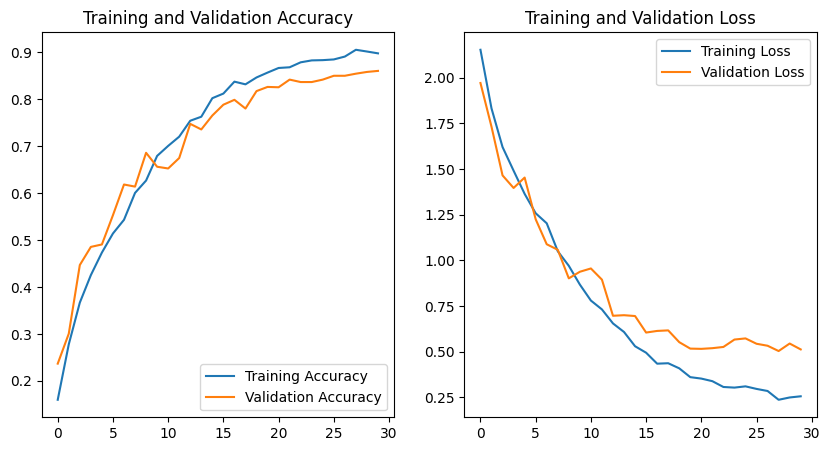

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Final Observations:

s 31ms/step - loss: 0.2564 - accuracy: 0.8978 - val_loss: 0.5129 - val_accuracy: 0.8604

- Training Loss: 0.2564

- Training Accuracy: 89%

- Validation Loss: 0.5129

- Validation Accuracy: 86%

**Training Performance:** The training loss is relatively low at 0.2564, indicating that the model is fitting the training data quite well. This suggests that the model is learning the patterns within the training data with a high degree of accuracy, achieving a training accuracy of 89%.

**Validation Performance: ** While the validation loss is higher than the training loss, which is expected, it remains relatively low at 0.5129. This indicates that the model is performing well on data it hasn't seen during training. The validation accuracy of 86% reflects the model's ability to generalize to new, unseen data.

**Generalization:** The relatively small gap between the training accuracy (89%) and validation accuracy (86%) suggests that the model is not overfitting the training data. It demonstrates a good balance between learning from the training data and generalizing to new data.

**Model Capability:** These results imply that the model has been well-trained and is proficient in capturing the underlying patterns in the data. It has the potential for practical applications with a high level of accuracy in both training and validation.

Overall, the model appears to be well-trained and exhibits strong performance on both the training and validation datasets, indicating its potential for effective real-world use.